# Phase 1 - Model Testing with All Data
## Package Import

In [84]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import joblib
import os

## Data Import

In [85]:
df = pd.read_csv('../../data/cleaned-yearly-ETFs.csv')
print(df.columns)
df.head()

Index(['fund_symbol', 'price_year', 'avg_open', 'avg_high', 'avg_low',
       'avg_close', 'avg_adj_close', 'avg_transaction_price',
       'avg_transaction_volume', 'avg_transaction_value', 'yearly_risk',
       'yearly_loss'],
      dtype='object')


,fund_symbol,price_year,avg_open,avg_high,avg_low,avg_close,avg_adj_close,avg_transaction_price,avg_transaction_volume,avg_transaction_value,yearly_risk,yearly_loss
0,AAA,2020,24.989500,24.996000,24.985000,24.988750,24.799375,24.799375,6360.000000,1.575589e+05,0.000700,-0.002405
1,AAAU,2018,12.182737,12.229579,12.148947,12.171579,12.171579,12.171579,103495.789474,1.252533e+06,0.006177,-0.012490
2,AAAU,2019,13.921230,13.968056,13.873294,13.920317,13.920317,13.920317,57093.650794,8.173461e+05,0.007424,-0.023196
3,AAAU,2020,17.696047,17.776917,17.577036,17.681818,17.681818,17.681818,411806.719368,7.529092e+06,0.012494,-0.054978
4,AADR,2010,27.727478,27.799913,27.633565,27.734522,26.044261,26.044261,5478.260870,1.424816e+05,0.009560,-0.034893


## Data Preprocessing

In [86]:
df = df[(df['price_year'] == 2020)]
df['yearly_risk'].describe(percentiles=[0.25, 0.5, 0.75])
df['yearly_risk'] = (df['yearly_risk'] > 0.10619).astype(int)

# Prepare data
X = df.drop(columns=['fund_symbol','price_year', 'yearly_risk']).to_numpy(dtype=np.float32)
y = df['yearly_risk'].to_numpy(dtype=np.float32)
fund_symbols = df['fund_symbol'].to_numpy() 

In [87]:
df.shape

(2118, 12)

## Model 1: Preferential Attachment Model

In [88]:
# Create a directed graph for preferential attachment
G = nx.DiGraph()

# initialize graph
for i in range(5):
    G.add_node(i, fund_symbol=fund_symbols[i])

# add edges with prefferential attachment method 
for new_node in range(5, len(df)):
    degrees = np.array([G.degree(n) for n in G.nodes()])
    if degrees.sum() > 0:
        probabilities = degrees / degrees.sum()
    #assume unif if small
    else:
        probabilities = np.ones(len(G.nodes())) / len(G.nodes())
    target_node = np.random.choice(G.nodes(), p=probabilities)
    G.add_edge(new_node, target_node)

# get node features and add to df
degree_features = np.array([G.degree(i) for i in range(len(fund_symbols))]).reshape(-1, 1)
neighbor_degree_features = np.array([np.mean([G.degree(n) for n in G.neighbors(i)]) for i in range(len(fund_symbols))]).reshape(-1, 1)
X_combined = np.hstack((X, degree_features, neighbor_degree_features))
mask = ~np.isnan(X_combined).any(axis=1)
X_combined = X_combined[mask]
y_pa = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_pa, test_size=0.2, random_state=42)

# classify with k-nearest neighbors
model = KNeighborsClassifier(n_neighbors=5)

# fit model with training data
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#save model
joblib.dump(model, './model_PA.joblib')

/Users/tori/Desktop/Georgetown/Summer-2024/DSAN.6500/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tori/Desktop/Georgetown/Summer-2024/DSAN.6500/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       423

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



['./model_PA.joblib']

### Get features for Gephi visualization

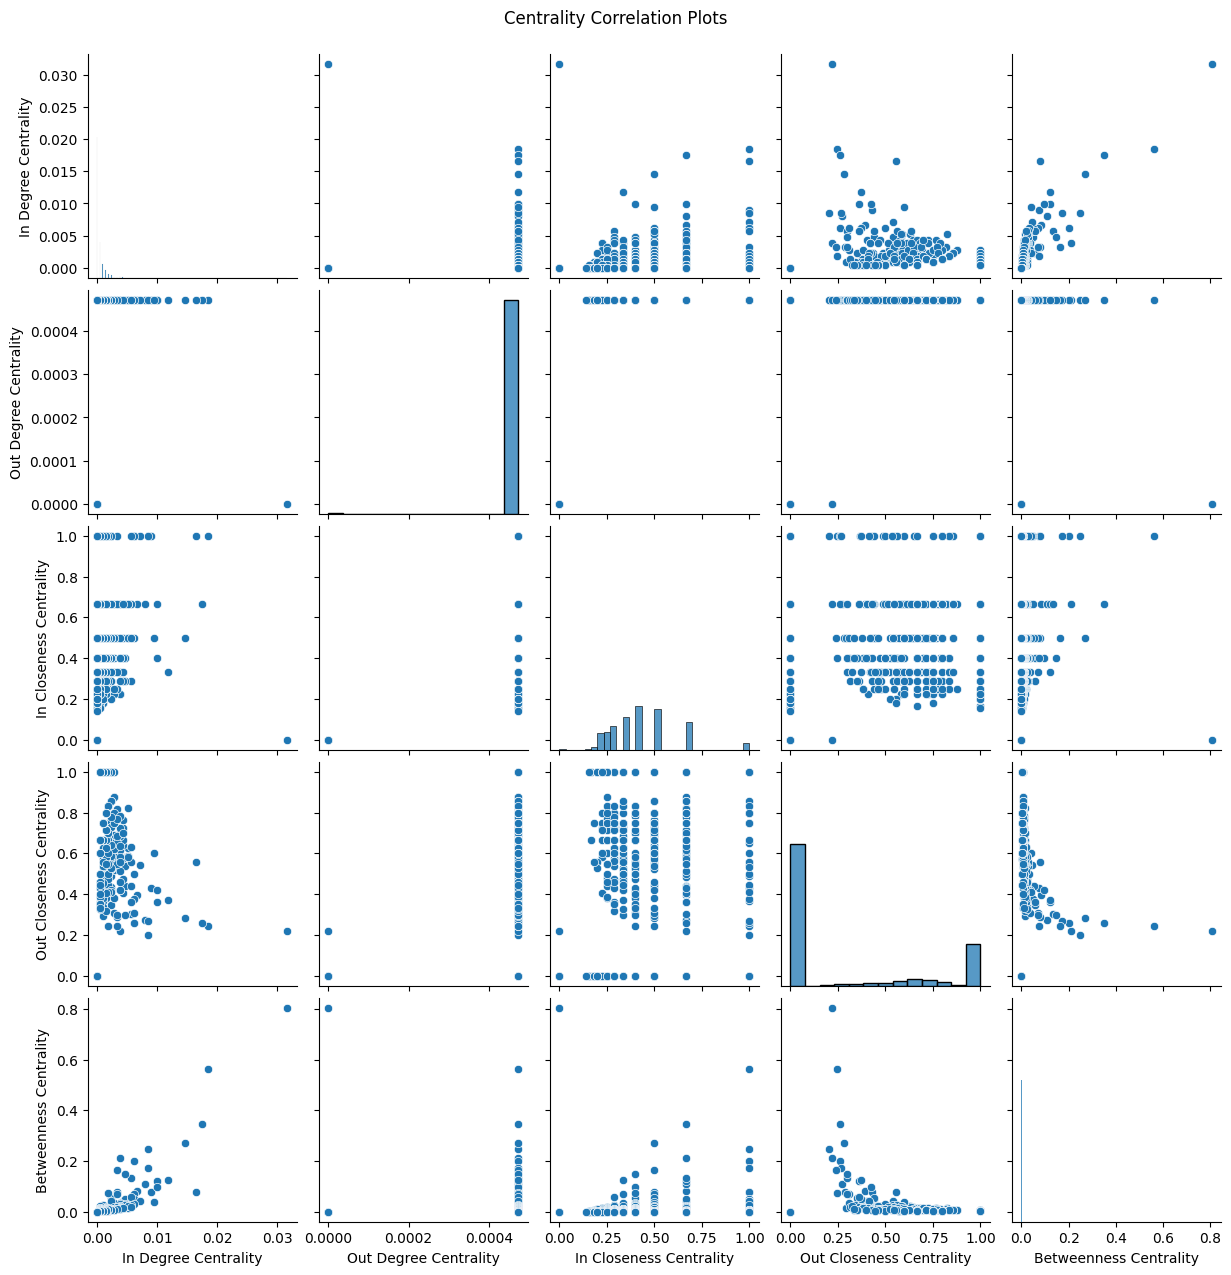

Average In-Degree:  0.997639282341832
Average Out-Degree:  0.997639282341832
GENERAL
	number of nodes: 2118
	number of edges: 2113
	is_directed: True
	is_weighted: False
IN-DEGREE (NORMALIZED)
	min: 0.0
	mean: 0.0004712514323768693
	median: 0.0
	max: 0.03164855928200284
	top nodes: [3, 5, 18, 33, 26, 77]
	           [0.03164855928200284, 0.018422295701464336, 0.01747756258856873, 0.016532829475673125, 0.01464336324988191, 0.011809163911195087]
OUT-DEGREE (NORMALIZED)
	min: 0.0
	mean: 0.00047125143237686934
	median: 0.0004723665564478035
	max: 0.0004723665564478035
	top nodes: [5, 6, 7, 8, 9, 10]
	           [0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035]


In [89]:
import nx_tools as nxt

nxt.plot_centrality_correlation(G,path="centrality-degree-plots-2020.pdf")
nxt.ave_degree(G)
nxt.network_summary(G)

In [90]:
# Add node features, predictions, and fund symbols as attributes in the graph
for i, node in enumerate(G.nodes()):
    if i < len(X_combined):
        G.nodes[node]['degree'] = degree_features[i, 0]
        G.nodes[node]['neighbor_degree'] = neighbor_degree_features[i, 0]
        G.nodes[node]['prediction'] = model.predict([X_combined[i]])[0]
        G.nodes[node]['label'] = fund_symbols[i]  
    else:
        G.nodes[node]['degree'] = 0
        G.nodes[node]['neighbor_degree'] = 0
        G.nodes[node]['prediction'] = -1  
        G.nodes[node]['label'] = "Unknown"  
        
# Export the graph with attributes to GEXF format for Gephi
nx.write_gexf(G, "2020-graph.gexf")

## Model 2: Neural Network Model

In [91]:

# Data to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)  

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Get device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Define NN class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2) 
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Instantiate model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Get unique fund symbols
fund_symbols = df['fund_symbol'].to_numpy()

# Create a directed graph for preferential attachment
G = nx.DiGraph()

# Initialize nodes in the graph
for i in range(len(fund_symbols)):
    G.add_node(i, label=fund_symbols[i])  # Set fund_symbol as 'label'

# Add edges with preferential attachment method
for new_node in range(len(fund_symbols)):
    if len(G.nodes()) == 0:
        target_node = new_node
    else:
        degrees = np.array([G.degree(n) for n in G.nodes()])
        if degrees.sum() > 0:
            probabilities = degrees / degrees.sum()
        else:
            probabilities = np.ones(len(G.nodes())) / len(G.nodes())
        target_node = np.random.choice(list(G.nodes()), p=probabilities)
    G.add_edge(new_node, target_node)

# Test the model
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_pred_logits = model(X_test)
    y_pred = torch.argmax(y_pred_logits, dim=1).cpu().numpy() 

# classification metrics
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
report = classification_report(y_test.cpu().numpy(), y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Save model
joblib.dump(model, './full_model_nn.joblib')

Accuracy: 0.9929245283018868
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       421
           1       0.00      0.00      0.00         3

    accuracy                           0.99       424
   macro avg       0.50      0.50      0.50       424
weighted avg       0.99      0.99      0.99       424



/Users/tori/Desktop/Georgetown/Summer-2024/DSAN.6500/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tori/Desktop/Georgetown/Summer-2024/DSAN.6500/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tori/Desktop/Georgetown/Summer-2024/DSAN.6500/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

['./full_model_nn.joblib']

In [92]:
# Add node features and predictions as attributes
for i, node in enumerate(G.nodes()):
    if i < len(X_combined):
        G.nodes[node]['degree'] = degree_features[i, 0]
        G.nodes[node]['neighbor_degree'] = neighbor_degree_features[i, 0]
        G.nodes[node]['label'] = fund_symbols[i]  # Use fund symbol as label
    else:
        G.nodes[node]['degree'] = 0
        G.nodes[node]['neighbor_degree'] = 0
        G.nodes[node]['label'] = "Unknown"  # Use "Unknown" or some default value

# Export the graph with attributes to GEXF format for Gephi
nx.write_gexf(G, "2020-nn.gexf")


In [93]:
nxt.ave_degree(G)
nxt.network_summary(G)

Average In-Degree:  1.0
Average Out-Degree:  1.0
GENERAL
	number of nodes: 2118
	number of edges: 2118
	is_directed: True
	is_weighted: False
IN-DEGREE (NORMALIZED)
	min: 0.0
	mean: 0.0004723665564478035
	median: 0.0
	max: 0.030231459612659425
	top nodes: [0, 5, 1136, 35, 22, 45]
	           [0.030231459612659425, 0.02267359470949457, 0.02267359470949457, 0.02031176192725555, 0.015588096362777516, 0.015115729806329713]
OUT-DEGREE (NORMALIZED)
	min: 0.0004723665564478035
	mean: 0.00047236655644780363
	median: 0.0004723665564478035
	max: 0.0004723665564478035
	top nodes: [0, 1, 2, 3, 4, 5]
	           [0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035, 0.0004723665564478035]


Both models performed with extremely high accuracy. The PA model performed at 99.7% accuracy, whereas the neural network performed at 99.8% accuracy. It should be noted that the PA model required some input firms to be dropped (9). It should also be noted that the neural network requires higher computational power.